#The Apparent Steps to Importing and Creating the U-Net Model (Subject to change as we iterate through experimentation)



#Module Imports

First, we will import the Tensorflow and Tensorflow Datasets modules, which will be necessary for what we need to model.

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

Tensorflow_examples is a module by Tensorflow that holds various proven pretrained model examples. We will use the !pip install git command to import the necessary libraries from Tensorflow's examples repository.

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ycq6cspb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ycq6cspb


Now, from tensorflow_examples, we can import the pix2pix model, which is made to create models that map from the original image a new image specifying a certain prediction.

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

#Model Creation

We will now import the model over, making sure the input shape is 128x128x3, which this particular pretrained model accepts. We will have to shape the input image maps accordingly.

U-Nets operate by creating an up and down scaling process. We will first create the down stacking process,with the purpose of downsizing the image into about 16x16.

In [4]:
baseModel = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

layerNames = [
              'block_1_expand_relu',
              'block_3_expand_relu',
              'block_6_expand_relu',
              'block_13_expand_relu',
              'block_16_project',
]

baseModelOutputs = [baseModel.get_layer(name).output for name in layerNames]

downStack = tf.keras.Model(inputs=baseModel.input,outputs=baseModelOutputs)

downStack.trainable=False

Now we will create the up scaling process, which will bring the image back into 128x128 shape.

In [5]:
upStack = [
           pix2pix.upsample(512,3),
           pix2pix.upsample(256,3),
           pix2pix.upsample(128,3),
           pix2pix.upsample(64,3),
]

Now, we will create the method that will instantiate the model, using the upstack and downstack created earlier.

Extra Note: To make sure the model generalizes to the testing data, we included a Dropout layer after each layer of the pretrained model. It will randomly dropout 25% of the weight calculations. This will mitigate overfitting when we run our model.

In [6]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128,128,3])

  skips = downStack(inputs)
  x=skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(upStack,skips):
    x=up(x)
    concat =tf.keras.layers.Concatenate()
    x = concat([x,skip])
    x= tf.keras.layers.Dropout(0.25)(x)
  last = tf.keras.layers.Conv2DTranspose(filters=output_channels,kernel_size=3,strides=2,padding='same')
  x=last(x)
  return tf.keras.Model(inputs=inputs,outputs=x)
  

We will now use this method to create our U-Net model. Note that we set outputClasses to 1 because this will match the shape of the binary masks the model will train on.

In [69]:
outputClasses = 1

model = unet_model(output_channels=outputClasses)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

We'll plot the model to view each layer and see if it reflects the U-Net model shape. We can see that it does.

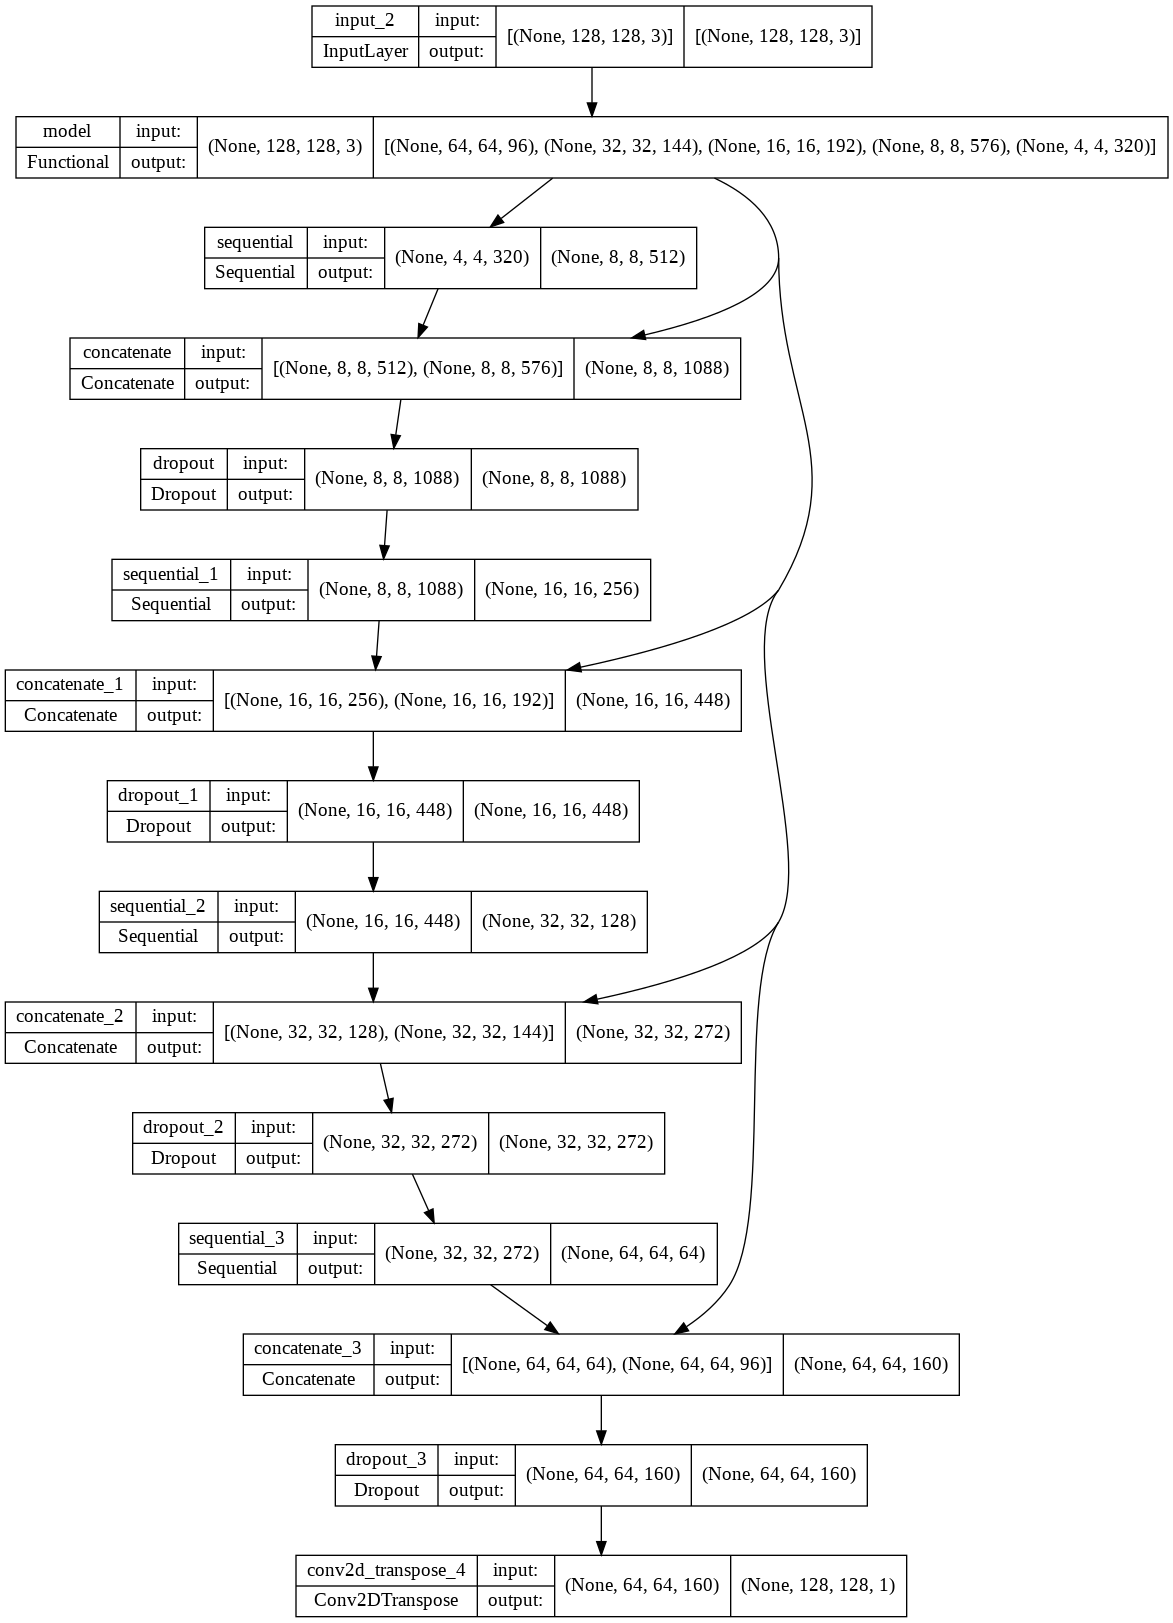

In [8]:
tf.keras.utils.plot_model(model,show_shapes=True)

#Data Preparation

We will now create our dataset by grabbing our training and testing data. The reasoning and details for each steps are explained in the CreatingDataset colab.

In [9]:
!unzip FA_ordered.zip
!unzip Mask_ordered.zip

Archive:  FA_ordered.zip
replace FA_ordered/FA001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: FA_ordered/FA001.png    
  inflating: FA_ordered/FA002.png    
  inflating: FA_ordered/FA003.png    
  inflating: FA_ordered/FA004.png    
  inflating: FA_ordered/FA005.png    
  inflating: FA_ordered/FA006.png    
  inflating: FA_ordered/FA007.png    
  inflating: FA_ordered/FA008.png    
  inflating: FA_ordered/FA009.png    
  inflating: FA_ordered/FA010.jpg    
  inflating: FA_ordered/FA011.jpg    
  inflating: FA_ordered/FA012.jpg    
  inflating: FA_ordered/FA013.jpg    
  inflating: FA_ordered/FA014.jpg    
  inflating: FA_ordered/FA015.jpg    
  inflating: FA_ordered/FA016.jpg    
  inflating: FA_ordered/FA017.jpg    
  inflating: FA_ordered/FA018.jpg    
  inflating: FA_ordered/FA019.jpg    
  inflating: FA_ordered/FA020.jpg    
  inflating: FA_ordered/FA021.jpg    
  inflating: FA_ordered/FA022.jpg    
  inflating: FA_ordered/FA023.jpg    
  inflating: FA_ordered/FA024.j

['FA001.png', 'FA002.png', 'FA003.png', 'FA004.png', 'FA005.png', 'FA006.png', 'FA007.png', 'FA008.png', 'FA009.png', 'FA010.jpg', 'FA011.jpg', 'FA012.jpg', 'FA013.jpg', 'FA014.jpg', 'FA015.jpg', 'FA016.jpg', 'FA017.jpg', 'FA018.jpg', 'FA019.jpg', 'FA020.jpg', 'FA021.jpg', 'FA022.jpg', 'FA023.jpg', 'FA024.jpg', 'FA025.jpg', 'FA026.jpg', 'FA027.jpg', 'FA028.jpg', 'FA029.jpg', 'FA030.jpg', 'FA031.jpg', 'FA032.jpg', 'FA033.jpg', 'FA034.jpg', 'FA035.jpg', 'FA036.jpg', 'FA037.jpg', 'FA038.jpg', 'FA039.jpg', 'FA040.jpg', 'FA041.jpg', 'FA042.jpg', 'FA043.jpg', 'FA044.jpg', 'FA045.jpg', 'FA046.jpg', 'FA047.jpg', 'FA048.jpg', 'FA049.jpg', 'FA050.jpg', 'FA051.jpg', 'FA052.jpg', 'FA053.jpg', 'FA054.jpg', 'FA055.jpg', 'FA056.jpg', 'FA057.jpg', 'FA058.jpg', 'FA059.jpg', 'FA060.jpg', 'FA061.jpg', 'FA062.jpg', 'FA063.jpg', 'FA064.jpg', 'FA065.jpg', 'FA066.jpg', 'FA067.jpg', 'FA068.jpg', 'FA069.jpg', 'FA070.jpg', 'FA071.jpg', 'FA072.jpg', 'FA073.jpg', 'FA074.jpg', 'FA075.jpg', 'FA076.jpg', 'FA077.jpg'

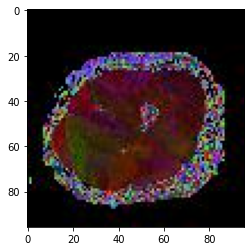

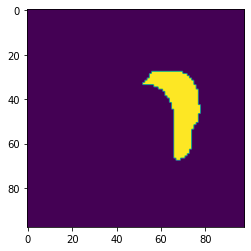

In [10]:
import os
import cv2
import numpy as np

train_image_dir = '/content/FA_ordered'
train_mask_dir = '/content/Mask_ordered'

train_image_list = sorted(os.listdir(train_image_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))
print(train_image_list)
print(train_mask_list)

import matplotlib.pyplot as plt
train_images = [cv2.imread(os.path.join(train_image_dir, train_image)) for train_image in train_image_list]
train_masks  = [cv2.imread(os.path.join(train_mask_dir, train_mask)) for train_mask in train_mask_list]

# Masks are grayscale, do the conversion.
train_masks = [cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)[:, :, np.newaxis] for mask in train_masks]

print(f'train_images[0].shape={train_images[0].shape}')
print(f'train_masks[0].shape={train_masks[0].shape}')

plt.imshow(train_images[0])
plt.show()
plt.imshow(train_masks[0][:, :, 0])
plt.show()

# Overlay the two images.
# sum_image = np.zeros(shape=train_masks[0].shape + (3,), dtype=train_masks[0].dtype)
# sum_image[1:-1, 1:-1, :] = train_images[0]
# sum_image = sum_image//2 + cv2.cvtColor(train_masks[0], cv2.COLOR_GRAY2BGR) // 2
# plt.imshow(sum_image)
# plt.show()


Another step to help generalization, we will create a function that will randomly flip and rotate images, and map this to our training images. We will also reshape the training and testing images and masks to match the required shape for our model.

(104, 128, 128, 3)
(104, 128, 128, 1)


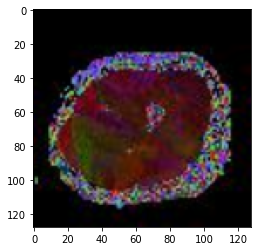

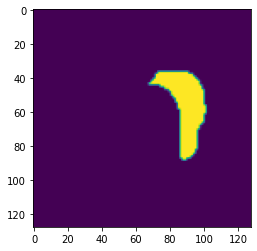

In [11]:
import tensorflow as tf
# trainImages = tf.keras.utils.image_dataset_from_directory('/content/FA_ordered/',shuffle=False,batch_size=1,labels=train_masks)
# testImages = tf.keras.utils.image_dataset_from_directory('/content/content/ModelData/Test/',shuffle=False,batch_size=1,labels=testMasks)

train_images = tf.image.resize(train_images, [128, 128])
train_masks = tf.image.resize(train_masks, [128, 128])
print(train_images.shape)
print(train_masks.shape)

plt.imshow(train_images[0] / 255.0)
plt.show()
plt.imshow(train_masks[0][:, :, 0] / 255.0)
plt.show()

# Overlay the two images.
# TODO(avirodov): broadcast mask to rgb for visualization.
# plt.imshow(train_images[0] / 512.0 + np.stack((train_masks[0], train_masks[0], train_masks[0])) / 512.0)
# plt.show()


In [12]:
def dataAugmentation(image, mask):
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(.5, .2),])
  return data_augmentation(image),data_augmentation(mask)

# trainImages=  trainImages.map(dataAugmentation)

#Model Training

Now we will train on the model. We will add an EarlyStpping callback to make sure the validated loss does not change too detrimentally.

In [80]:
print(f'{train_images.shape}')
print(f'{train_masks.shape}')
print(f'{tf.math.reduce_min(train_images)}')
print(f'{tf.math.reduce_max(train_images)}')
print(f'{tf.math.reduce_min(train_masks)}')
print(f'{tf.math.reduce_max(train_masks)}')

train_images_normalized = ((train_images / 255.0) * 2.0 - 1.0) # TODO: there are better ways to normalize the image I think.
train_masks_normalized = train_masks / 255.0


(104, 128, 128, 3)
(104, 128, 128, 1)
0.0
250.203125
0.0
255.0


In [81]:
epochs = 20

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
history = model.fit(train_images_normalized, train_masks_normalized, epochs=epochs, batch_size=1) #,validation_data=testImages)

Epoch 1/20
104/104 [==============================] - 2s 16ms/step - loss: 0.0190 - accuracy: 0.9827
Epoch 2/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0184 - accuracy: 0.9828
Epoch 3/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0186 - accuracy: 0.9828
Epoch 4/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0186 - accuracy: 0.9829
Epoch 5/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0181 - accuracy: 0.9829
Epoch 6/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0183 - accuracy: 0.9829
Epoch 7/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0184 - accuracy: 0.9829
Epoch 8/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0181 - accuracy: 0.9829
Epoch 9/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0189 - accuracy: 0.9827
Epoch 10/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0176 - accura

(3, 128, 128, 1)


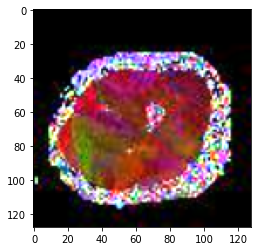

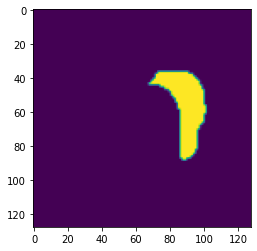

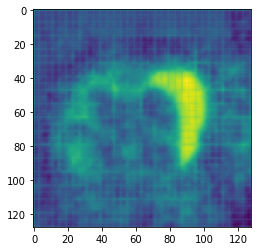

In [82]:
result = model.predict(train_images_normalized[0:3])
print(f'{result.shape}')
plt.imshow((train_images_normalized[0, :, :] + 1.0))
plt.show()
plt.imshow(train_masks_normalized[0, :, :, 0])
plt.show()
plt.imshow(result[0, :, :, 0] * 255.0)
plt.show()
# a_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# loss_value = a_loss(result, train_masks_normalized[0:3])
# print(f'{loss_value}')


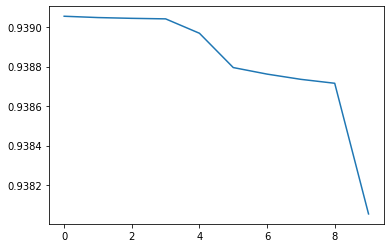

In [ ]:
plt.plot(history.history['val_accuracy'])

Our model always had high validation accuracy, but we wanted to mitigate the validated los we were experiencing. We see below that the validation loss is much more controlled.

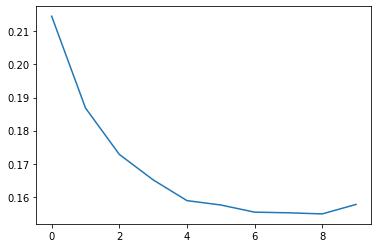

In [ ]:
plt.plot(history.history['val_loss'])

Let's look at our training predictions. We expect this to have very high accuracy like before.

In [ ]:
trainBatch = []
trainMask = []
for t in testImages:
  trainBatch.append(t[0])
  trainMask.append(t[1])

predictions = model.predict(np.array(trainBatch).reshape(-1,128,128,3))

In [ ]:
indexNumber = 1

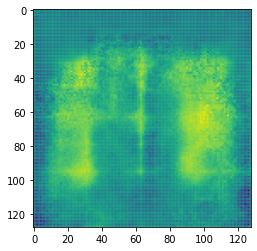

In [ ]:
plt.imshow(predictions[indexNumber].reshape(128,128))

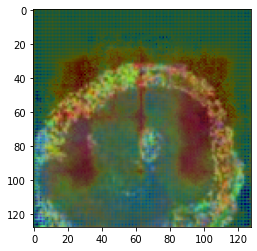

In [ ]:
plt.imshow(trainBatch[indexNumber][0],cmap='gray')
plt.imshow(np.array(predictions[indexNumber]).reshape(128,128),cmap='jet',alpha=0.35)

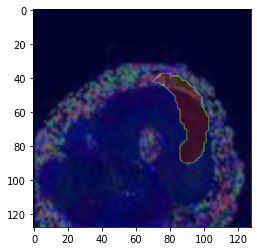

In [ ]:
plt.imshow(trainBatch[indexNumber][0],cmap='gray')
plt.imshow(np.array(trainMask[indexNumber]).reshape(128,128),cmap='jet',alpha=0.35)

Now let's try the validation data.

In [ ]:
testBatch = []
testMask = []
for t in testImages:
  testBatch.append(t[0])
  testMask.append(t[1])

predictions = model.predict(np.array(testBatch).reshape(-1,128,128,3))

In [ ]:
indexNumber = 5

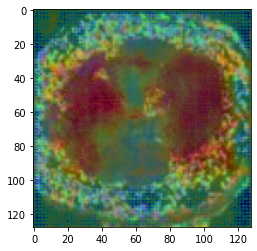

In [ ]:
plt.imshow(testBatch[indexNumber][0],cmap='gray')
plt.imshow(np.array(predictions[indexNumber]).reshape(128,128),cmap='jet',alpha=0.35)

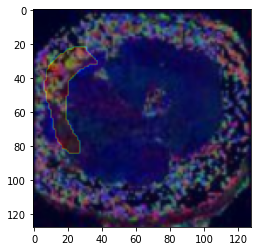

In [ ]:
plt.imshow(testBatch[indexNumber][0],cmap='gray')
plt.imshow(np.array(testMask[indexNumber]).reshape(128,128),cmap='jet',alpha=0.25)

The model now seems to be able to highlight the general area the muscle is located at. Our validation accuracy is now around 70%.

In [ ]:
metrics = model.evaluate(testImages)

print(abs(metrics[1]-metrics[0]))
print(predictions.shape)

46/46 [==============================] - 0s 9ms/step - loss: 0.1577 - accuracy: 0.9381
0.780366450548172
(46, 128, 128, 1)


#Returning the Model Outputs as .mat files

We want to be able to show the model's predictions through a binary mask similar to the input binary masks that were given. In order to do this, we need to convert our values in a way that can be represented as either 0 and 1.

We will use Sklearn's MinMaxScaler, which can interpret and scale down numbers to be between 0 and 1, similar to what a sigmoid function would do.

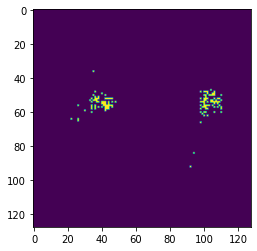

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

predictionMasks = []

for p in predictions:
  p = p.flatten().reshape(-1,1)
  p= scaler.fit_transform(p)
  p=[1 if prediction>0.9 else 0 for prediction in p]
  # p = np.round(scaler.fit_transform(p),0)
  p = np.array(p).reshape(-1,128,128,1)
  predictionMasks.append(p)

plt.imshow(predictionMasks[5].reshape(128,128))

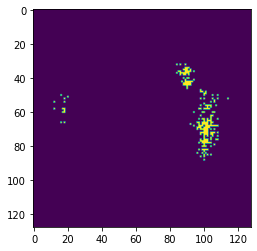

In [ ]:
plt.imshow(predictionMasks[45].reshape(128,128))

Next, we will create the folders where we will store the images as well as the prediction masks.

In [ ]:
!mkdir ImagesandPredictions/
!mkdir ImagesandPredictions/Images/
!mkdir ImagesandPredictions/Predictions/

Now, using the PIL module, we will save the images into .jpeg format as we always did.

Additionally, we will save the binary masks as .mat files.

In [ ]:
from PIL import Image
import scipy.io
getTestImages = np.array(testBatch).reshape(-1,128,128,3)

imageDirectory = '/content/ImagesandPredictions/Images/'

predictionDirectory = '/content/ImagesandPredictions/Predictions/'
counter = 1

for g in getTestImages:
  Image.fromarray(g).save(f'{imageDirectory}image_map{counter}.jpeg')
  counter+=1

counter=1
for p in predictionMasks:
  predictionDictionary = {'img':p}
  scipy.io.savemat(f'{predictionDirectory}binary_mask{counter}.mat',predictionDictionary)
  counter+=1

Now that we stored all of the data in the appropriate folders, we will zip the file.

In [ ]:
!zip -r /content/ImagesandPredictions.zip /content/ImagesandPredictions/

  adding: content/ImagesandPredictions/ (stored 0%)
  adding: content/ImagesandPredictions/Images/ (stored 0%)
  adding: content/ImagesandPredictions/Images/image_map40.jpeg (deflated 4%)
  adding: content/ImagesandPredictions/Images/image_map24.jpeg (deflated 5%)
  adding: content/ImagesandPredictions/Images/image_map29.jpeg (deflated 3%)
  adding: content/ImagesandPredictions/Images/image_map43.jpeg (deflated 3%)
  adding: content/ImagesandPredictions/Images/image_map19.jpeg (deflated 3%)
  adding: content/ImagesandPredictions/Images/image_map34.jpeg (deflated 6%)
  adding: content/ImagesandPredictions/Images/image_map14.jpeg (deflated 3%)
  adding: content/ImagesandPredictions/Images/image_map13.jpeg (deflated 4%)
  adding: content/ImagesandPredictions/Images/image_map39.jpeg (deflated 4%)
  adding: content/ImagesandPredictions/Images/image_map31.jpeg (deflated 4%)
  adding: content/ImagesandPredictions/Images/image_map21.jpeg (deflated 3%)
  adding: content/ImagesandPredictions/Ima